In [2]:
%matplotlib inline
import importlib
from pytorch_utils_oh_2 import *
import IPython

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
MODEL_SAVE_PATH = 'electronic_gen_2_testing_no_bidirect'

In [5]:
import pytorch_utils_oh_2; importlib.reload(pytorch_utils_oh_2); from pytorch_utils_oh_2 import *;

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


# Data loading

In [6]:
# all_data = pickle.load(open("data/en_train_fixed_4_sentences.pkl", "rb" ))
all_data = pickle.load(open("data/en_train_fixed_5_manual.pkl", "rb" ))
# all_data_sentence_index = all_data.set_index('sentence_id')

In [7]:
sample_data = all_data.copy()
sample_data = sample_data[sample_data['class'] == 'ELECTRONIC']
print("Data rows: {},  (dropped rows: {})".format(len(sample_data), len(all_data)-len(sample_data)))
sample_data = sample_data.reset_index(drop=True)
del(all_data)

Data rows: 4964,  (dropped rows: 9913228)


In [8]:
categories_all = sorted(sample_data["class"].unique())
print(categories_all)
print(len(categories_all))
categories_index = dict((c, i) for i, c in enumerate(categories_all))

['ELECTRONIC']
1


### Utils stuff

In [9]:
chars_normal, chars_normal_index = load_characters_pkl('data/en_features/chars_normal.pkl')
print(''.join(chars_normal))

<SOS><EOS>☒ !"#$%&'(),-./0123456789:;ABCDEFGHIJKLMNOPQRSTUVWXYZ_abcdefghijklmnopqrstuvwxyz~£¥ª²³µº¼½¾éɒʻˈΩμ—€⅓⅔⅛


common_words, common_words_index = load_common_words_10k()
len(common_words)
common_words[0:10]

In [10]:
wv_vecs, wv_words, wv_idx = load_glove('/home/ohu/koodi/data/glove_wordvec/glove.6B.50d.txt')

### After words handling

In [11]:
words_after_common = pickle.load(open("data/en_features/words_after_ext.pkl", 'rb'))
words_after_index = dict((c, i) for i, c in enumerate(words_after_common))
words_after_common[0:7]
len(words_after_common)

['<EOS>', '<SOS>', '<UNK>', '<0000>', '<SAMPLE>', 'two', 'twenty']

1351

In [12]:
sos_tensor = torch.zeros(1, 1, len(words_after_index))
sos_tensor[0, 0, words_after_index[SOS_TOKEN]] = 1
sos_tensor.size()
#del(onehot_sos)

# sos_tensor = torch.LongTensor([words_after_index[SOS_TOKEN]])

torch.Size([1, 1, 1351])

### More balanced sample

In [13]:
balanced_data_classes_select = list(sample_data.groupby('class'))

balanced_data_accessed_counter = 0 
balanced_data_randomize_freq = False
balanced_data_length = 0

def balanced_data_randomize_org(max_len=20000):
    global balanced_data, balanced_data_length, balanced_data_accessed_counter, balanced_data_randomize_freq
    balanced_data = pd.concat([v.sample(min(max_len, len(v))) for k, v in balanced_data_classes_select])
    balanced_data_length = len(balanced_data)
    balanced_data_randomize_freq = balanced_data_length * 0.2
    balanced_data_accessed_counter = 0
balanced_data_randomize = balanced_data_randomize_org

def balanced_data_sample_row():
    global balanced_data_accessed_counter
    global balanced_data_last_sample
    balanced_data_accessed_counter += 1
    #if balanced_data_randomize_freq and balanced_data_accessed_counter > balanced_data_randomize_freq:
    #    balanced_data_randomize()
    balanced_data_last_sample = balanced_data.iloc[random.randint(1, balanced_data_length-1)]
    return balanced_data_last_sample
    
balanced_data_randomize()

In [14]:
len(sample_data)

4964

In [15]:
#all_data.groupby('class')['class'].count()
#sample_data.groupby('class')['class'].count()
balanced_data.groupby('class')['class'].count()

class
ELECTRONIC    4964
Name: class, dtype: int64

In [16]:
balanced_data_sample_row()

sentence_id                                               182347
token_id                                                      12
class                                                 ELECTRONIC
before                                               NYTimes.com
after                                    n y t i m e s dot c o m
class_org                                             ELECTRONIC
a_word_ind       [29, 86, 30, 31, 32, 28, 17, 74, 21, 25, 32, 0]
sentence       " caroline azar — about this person — movies &...
Name: 1130, dtype: object

### Samples

In [17]:
def get_random_sample():
    sample_row = balanced_data_sample_row()   
    return sample_row['before'], sample_row['a_word_ind'], sample_row['class'], sample_row['sentence']
            
def tmp():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    s_aft_str = ' '.join([words_after_common[i] for i in s_aft])
    print(s_class, ':', s_bef, '->', s_aft_str, s_aft)
    print(s_sentence)
    print(string_to_tensor(s_bef, chars_normal_index).shape)
tmp()

ELECTRONIC : http://llt.msu.edu/vol10num1/fitzdebski/default.html -> h t t p colon slash slash l l t dot m s u dot e d u slash v o l u m e t e n n u m o n e slash f i t z d e b s k i slash d e f a u l t dot h t m l <EOS> [45, 30, 30, 24, 129, 101, 101, 42, 42, 30, 74, 32, 17, 43, 74, 28, 26, 43, 101, 54, 25, 42, 43, 32, 28, 30, 28, 29, 29, 43, 32, 25, 29, 28, 101, 37, 31, 30, 105, 26, 28, 36, 17, 59, 31, 101, 26, 28, 37, 22, 43, 42, 30, 74, 45, 30, 32, 42, 0]
retrieved 10 august 2006 from <SAMPLE> .
torch.Size([1, 53, 104])


In [23]:
%%timeit
get_random_sample()

137 µs ± 1.53 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Model functions

In [18]:
use_cuda = True

In [19]:
MAX_ATTENTION_LENGTH = 100

In [20]:
tmp = sample_data[sample_data['before'].str.len()>MAX_ATTENTION_LENGTH]
len(tmp)
tmp.sample(2)
tmp[~tmp['before'].str.contains('/')].sample(2)

106

,sentence_id,token_id,class,before,after,class_org,a_word_ind,sentence
3351,506099,18,ELECTRONIC,http://www.landofthebrave.info/colonial-times....,h t t p colon slash slash w w w dot l a n d o ...,ELECTRONIC,"[45, 30, 30, 24, 129, 101, 101, 52, 52, 52, 74...","p . h . spectre and d . larkin , wooden shp ( ..."
787,132576,24,ELECTRONIC,http://www.kickspeed.com.au/Improve-measure-ki...,h t t p colon slash slash w w w dot k i c k s ...,ELECTRONIC,"[45, 30, 30, 24, 129, 101, 101, 52, 52, 52, 74...","hewitt ( 2006 ) , p . 42 hewitt ( 2006 ) , p ...."


,sentence_id,token_id,class,before,after,class_org,a_word_ind,sentence
2187,339237,6,ELECTRONIC,Resultsnola.combestofneworleans.comthehullabal...,r e s u l t s n o l a dot c o m b e s t o f n ...,ELECTRONIC,"[35, 28, 17, 43, 42, 30, 17, 29, 25, 42, 22, 7...","broadway to vegas february 15 , 2004 newslibra..."
2021,313820,0,ELECTRONIC,Findagrave.comFindagrave.comFindagrave.comFind...,f i n d a g r a v e dot c o m f i n d a g r a ...,ELECTRONIC,"[37, 31, 29, 26, 22, 53, 35, 22, 54, 28, 74, 2...","<SAMPLE> "" hibbard , spencer , bartlett & co "" ."


### Encoder

In [21]:
class EncoderRNN(nn.Module):
    def __init__(self, words_input_size, chars_input_size, words_hidden_size, chars_hidden_size,
                 words_layers=1, chars_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.words_layers = words_layers
        self.chars_layers = chars_layers
        self.words_hidden_size = words_hidden_size
        self.chars_hidden_size = chars_hidden_size
        self.hidden_size = words_hidden_size + chars_hidden_size

        self.rnn_words = nn.LSTM(words_input_size, words_hidden_size // 2, words_layers,
                                 batch_first=True, bidirectional=True)

        self.rnn_chars = nn.LSTM(chars_input_size, chars_hidden_size, chars_layers,
                                 batch_first=True, bidirectional=False)
                                #batch_first=True, bidirectional=True)
        
    def forward(self, word_vectors, string_tensor, hidden = None, init_hidden = True):
        if init_hidden:
            hidden_words, hidden_chars = self.init_hidden()
        
        all_outputs_words, hidden_words = self.rnn_words(word_vectors, hidden_words)
        output_words = all_outputs_words[:, -1]
        
        all_outputs_chars, hidden_chars = self.rnn_chars(string_tensor, hidden_chars)
        output_chars = all_outputs_chars[:, -1]
        
        hidden_states_cat = Variable(torch.zeros(MAX_ATTENTION_LENGTH, self.hidden_size)).cuda()
        for ei in range(min(MAX_ATTENTION_LENGTH, len(string_tensor[0]))):
            hidden_states_cat[ei] = torch.cat((output_words, all_outputs_chars[0, ei].view(1,-1)), 1)
                
        output = torch.cat((output_words[0], output_chars[0]), 0)

        #output = torch.cat((output_words, output_chars), 1)
        
        #return output, all_outputs_chars
        return output, hidden_states_cat

    def init_hidden(self):
        var1_1 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var1_2 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var2_1 = Variable(torch.zeros(1 * self.chars_layers, 1, self.chars_hidden_size))
        var2_2 = Variable(torch.zeros(1 * self.chars_layers, 1, self.chars_hidden_size))
        
        var1_1 = var1_1.cuda(); var1_2 = var1_2.cuda()
        var2_1 = var2_1.cuda(); var2_2 = var2_2.cuda()
        return ((var1_1, var1_2), (var2_1, var2_2))
    
    
encoder_rnn = EncoderRNN(words_input_size=wv_vecs.shape[-1], chars_input_size=len(chars_normal),
                         words_hidden_size=128, chars_hidden_size=256,
                         words_layers=1, chars_layers=1).cuda()
encoder_rnn


EncoderRNN (
  (rnn_words): LSTM(50, 64, batch_first=True, bidirectional=True)
  (rnn_chars): LSTM(104, 256, batch_first=True)
)

In [22]:
def test_encoder_single_sample():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    print(s_bef)
    
    words_t = Variable(words_to_word_vectors_tensor(list(s_sentence), wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    return encoder_rnn(words_t, string_t), s_bef
    
(encoder_output, encoder_outputs), tmp = test_encoder_single_sample()
tmp
encoder_output.size()
encoder_outputs.size()
torch.eq(encoder_output, encoder_outputs[len(tmp)]).data.all()

Sports-reference.com


'Sports-reference.com'

torch.Size([384])

torch.Size([100, 384])

True

### Decoder

In [23]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, dropout_p=0.1, max_length=MAX_ATTENTION_LENGTH):
        super(DecoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        #self.rnn = nn.GRU(input_size, hidden_size, n_layers,
        self.rnn = nn.GRU(hidden_size, hidden_size, n_layers,
                                 batch_first=True, bidirectional=False)
        
        self.lin_out = nn.Linear(hidden_size, input_size)
        #self.softmax = nn.LogSoftmax()
        
        #self.embedding = nn.Embedding(input_size, hidden_size)
        self.emb_lin = nn.Linear(input_size, hidden_size)
        self.max_length = max_length
        self.attn = nn.Linear(hidden_size*2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        
    #def forward(self, char, hidden):
    def forward(self, last_input, hidden, encoder_outputs):
        #embedded = self.embedding(last_input).view(1, 1, -1)
        embedded = self.emb_lin(last_input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        #IPython.core.debugger.Pdb().set_trace()
        #attn_weights = F.softmax(self.attn(torch.cat((char[0], hidden[0]), 1)))
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)))
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        
        output = F.relu(output)
        output, hidden = self.rnn(output, hidden)

        output = F.log_softmax(self.lin_out(output[0]))
        return output, hidden, attn_weights
    
    def init_rest_hidden(self, input_var):
        if self.n_layers > 1:
            hid_var = Variable(torch.zeros(self.n_layers - 1, 1, self.hidden_size)).cuda()
            res = torch.cat((input_var, hid_var), 0)
            return res
        else:
            return input_var
        

decoder_rnn = DecoderRNN(input_size=len(words_after_common), hidden_size=encoder_output.size()[0], n_layers=1)
decoder_rnn = decoder_rnn.cuda()
decoder_rnn

tmp_outputs = Variable(torch.zeros(MAX_ATTENTION_LENGTH, encoder_output.size()[0])).cuda()
tmp_hiddens = decoder_rnn.init_rest_hidden(encoder_output.view(1,1,-1))
tmp = decoder_rnn(Variable(sos_tensor).cuda(), tmp_hiddens, tmp_outputs)
[v.size() for v in tmp]

DecoderRNN (
  (rnn): GRU(384, 384, batch_first=True)
  (lin_out): Linear (384 -> 1351)
  (emb_lin): Linear (1351 -> 384)
  (attn): Linear (768 -> 100)
  (attn_combine): Linear (768 -> 384)
  (dropout): Dropout (p = 0.1)
)

[torch.Size([1, 1351]), torch.Size([1, 1, 384]), torch.Size([1, 100])]

In [24]:
torch.bmm(torch.FloatTensor([1,0.1,0.1]).view(1,1,-1), torch.arange(0, 12).view(1,3,-1))


(0 ,.,.) = 
  1.2000  2.4000  3.6000  4.8000
[torch.FloatTensor of size 1x1x4]

In [25]:
tmp_outputs = Variable(torch.zeros(MAX_ATTENTION_LENGTH, encoder_output.size()[0])).cuda()
tmp_hiddens = decoder_rnn.init_rest_hidden(encoder_output.view(1,1,-1))
tmp = decoder_rnn(Variable(sos_tensor).cuda(), tmp_hiddens, tmp_outputs)
[v.size() for v in tmp]
print(tmp[0].topk(1)[1])
print(words_after_common[tmp[0].topk(1)[1].data[0][0]])

[torch.Size([1, 1351]), torch.Size([1, 1, 384]), torch.Size([1, 100])]

Variable containing:
 14
[torch.cuda.LongTensor of size 1x1 (GPU 0)]

five


# Training etc

### Accuracy

In [26]:
def test_model_single_sample(model=None, return_more=False, sample=False):
    decoder_rnn.eval()
    encoder_rnn.eval()
    
    if not sample:
        sample = get_random_sample()
    s_bef, s_aft, s_class, s_sentence = sample
        
    words_t = Variable(words_to_word_vectors_tensor(list(s_sentence), wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    encoder_output, encoder_outputs = encoder_rnn(words_t, string_t)
    
    #encoder_output = encoder_output.view(1,1,-1)
    
    decoder_hidden = decoder_rnn.init_rest_hidden(encoder_outputs[0].view(1,1,-1))
    decoder_input = Variable(sos_tensor).cuda()

    decoded_output = []
    decoder_attns_arr = []
    max_length = 20
    for _ in range(max_length):
        decoder_output, decoder_hidden, decoder_attns = decoder_rnn(decoder_input, decoder_hidden, encoder_outputs)
        decoder_attns_arr.append(decoder_attns)
        #return decoder_output

        topv, topi = decoder_output.data.topk(1)
        word_index = topi[0][0]
        word = words_after_common[word_index] # Use own prediction as next input
                
        if word == EOS_TOKEN:
            break

        decoded_output.append(word)
        
        #decoder_input = Variable(torch.LongTensor([word_index])).cuda()
        
        decoder_input = torch.zeros(1, 1, len(words_after_index))
        decoder_input[0, 0, word_index] = 1
        decoder_input = Variable(decoder_input).cuda()
    
    output = ' '.join(decoded_output)
    sample_target = ' '.join([words_after_common[w] for w in s_aft][:-1])
    
    decoder_rnn.train()
    encoder_rnn.train()
    
    if return_more:
        return output, decoded_output, decoder_attns_arr, sample
    
    return output, output, sample_target, sample
    
tmp = test_model_single_sample(None)
tmp

('five kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor',
 'five kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor',
 'v i p e r e x c h a n g e dot c o m',
 ('ViperExchange.com',
  [54, 31, 24, 28, 35, 28, 97, 21, 45, 22, 29, 53, 28, 74, 21, 25, 32, 0],
  'ELECTRONIC',
  '" track issue knocks <SAMPLE> from winning contention at laguna seca " .'))

In [27]:
def print_local_wrong_predictions(max_results=10):
    arr = get_some_wrong_predictions(None, test_model_single_sample, max_iterations=10000, max_results=max_results)
    for sample, predict, output in arr:
        s_bef, s_aft, s_class, s_sentence = sample
        print("{:<14} => {:<14} || {} \n{:>17} {}".format(s_bef, predict, s_aft, '', s_sentence, ))
print_local_wrong_predictions(2)

nytimes.com    => five five kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor || [29, 86, 30, 31, 32, 28, 17, 74, 21, 25, 32, 0] 
                  " gale storm , 87 , is dead ; earned television fame for her wholesome roles " , <SAMPLE> , june 29 , 2009 ; accessed december 14 , 2015 .
Amazon.de      => five kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor || [22, 32, 22, 105, 25, 29, 74, 26, 28, 0] 
                  <SAMPLE> ( in german ) .


In [28]:
%%time
test_model_accuracy(encoder_rnn, test_model_single_sample, n_sample=100)

Accuracy: 0.00% (       0/     100)
CPU times: user 2.34 s, sys: 20 ms, total: 2.36 s
Wall time: 2.35 s


0.0

### Training

In [29]:
def train(s_bef, s_aft, s_sentence, encoder_optimizer, decoder_optimizer, loss_function,
          use_teacher_forcing, max_length=20):
    
    words_t = Variable(words_to_word_vectors_tensor(list(s_sentence), wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    encoder_output, encoder_outputs = encoder_rnn(words_t, string_t)
    
    #encoder_output = encoder_output.view(1,1,-1)
    
    decoder_hidden = decoder_rnn.init_rest_hidden(encoder_outputs[0].view(1,1,-1))
    decoder_input = Variable(sos_tensor).cuda()
    
    ###
    target_arr = s_aft
    #target_arr = after_sentence_to_word_indexes(s_aft, include_eos=True)
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0
    
    decoded_output = []
    for i in range(len(target_arr)):
        decoder_output, decoder_hidden, decoder_attns = decoder_rnn(decoder_input, decoder_hidden, encoder_outputs)

        #decoder_target_i = chars_after_index[target_arr[i]]
        decoder_target_i = target_arr[i]
        decoder_target_i = Variable(torch.LongTensor([decoder_target_i])).cuda()
        loss += loss_function(decoder_output, decoder_target_i)
        
        topv, topi = decoder_output.data.topk(1)
        word_index = topi[0][0]
        word = words_after_common[word_index] # Use own prediction as next input
        decoded_output.append(word)
        
        if use_teacher_forcing:
            word_index = target_arr[i] # replace input with right target
        else:
            # use output normally as input 
            if word == EOS_TOKEN:
                break
                
        decoder_input = torch.zeros(1, 1, len(words_after_index))
        decoder_input[0, 0, word_index] = 1
        decoder_input = Variable(decoder_input).cuda()
        #decoder_input = Variable(torch.LongTensor([word_index])).cuda()
        
    if decoded_output[-1] == EOS_TOKEN:
        decoded_output = decoded_output[:-1]
        
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return ' '.join(decoded_output), (loss.data[0] / len(target_arr))


In [30]:
def train_iterations(n_iters=100000, lr=0.001, teacher_forcing_ratio=0.5,
                     print_every=10000, plot_every=1000):

    start = time.time()
    
    decoder_rnn.train()
    encoder_rnn.train()

    current_loss = 0
    current_loss_iter = 0

    encoder_optimizer = torch.optim.Adam(encoder_rnn.parameters(), lr=lr)
    decoder_optimizer = torch.optim.Adam(decoder_rnn.parameters(), lr=lr)
    loss_function = nn.NLLLoss()
    
    for iteration in range(1, n_iters + 1):
        model_training.iterations += 1
        
        use_teacher_forcing = random.random() < teacher_forcing_ratio
        
        s_bef, s_aft, s_class, s_sentence = get_random_sample()
        
        result, loss = train(s_bef=s_bef, s_aft=s_aft, s_sentence=s_sentence,
                             encoder_optimizer=encoder_optimizer, decoder_optimizer=decoder_optimizer,
                             loss_function=nn.NLLLoss(), use_teacher_forcing=use_teacher_forcing,
                             max_length=40 )
        
        current_loss += loss
        current_loss_iter += 1

        # Print iter number, loss, name and guess
        if iteration % print_every == 0:
            teacher_forcing_str = ""
            if use_teacher_forcing:
                teacher_forcing_str = "(forcing)"
            s_aft_sentence = ' '.join([words_after_common[w] for w in s_aft][:-1])
            correct = '✓' if result == s_aft_sentence else "✗: {}".format(s_aft_sentence)
            
            print("{:>6d} {:>4.0%} ({:>8}) {:>7.3f}   | {:>6.2f}: {} -> {} ({}) {}".format(
                      model_training.iterations, iteration/n_iters, time_since(start),
                      current_loss/current_loss_iter, loss,
                      s_bef, result, correct, teacher_forcing_str))

        # Add current loss avg to list of losses
        if iteration % plot_every == 0:
            model_training.losses.append(current_loss / plot_every)
            model_training.learning_rates.append(lr)
            current_loss = 0
            current_loss_iter = 0
            
        if model_training.iterations % 50000 == 0 or model_training.iterations == 10:
            model_training.save_models()
            acc = test_model_accuracy(encoder_rnn, test_model_single_sample)
            model_training.accuracy.append(acc)
    
    # test_model_accuracy(model, n_sample=10000)

In [31]:
model_training = ModelTraining(MODEL_SAVE_PATH, [encoder_rnn, decoder_rnn])

Save path: data/models/electronic_gen_2_testing_no_bidirect


In [32]:
train_iterations(n_iters=50, print_every=9, lr=0.0001)

     9  18% (   0m 0s)   7.195   |   7.18: //www.zirox.co.in/resources.htm -> five kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor kronor (✗: s l a s h s l a s h w w w dot z i r o x dot c o dot i n s l a s h r e s o u r c e s dot h t m) (forcing)
Saved model to data/models/electronic_gen_2_testing_no_bidirect/10_(EncoderRNN/DecoderRNN)
Accuracy: 0.00% (       0/   10000)
    18  36% (   4m 0s)   6.950   |   7.14: Newspaperarchive.com -> w kronor kronor <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> (✗: n e w s p a p e r a r c h i v e dot c o m) (forcing)
    27  54% (   4m 1s)   6.365   |   7.11: forbes.com -> w w <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> (✗: f o r b e s dot c o m) (f

In [33]:
train_iterations(n_iters=(1000-model_training.iterations), print_every=500, lr=0.0001)

   550  53% (  0m 37s)   3.203   |   3.19: http://articles.economictimes.indiatimes.com/2011-12-17/news/30528703_1_indian-tea-industry-tea-production-tea-estateshttp://www.thehindu.com/todays-paper/tp-features/tp-metroplus/kadak-chai/article4250743.ece -> h e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e (✗: h t t p colon slash slash a r t i c l e s dot e c o n o m i c t i m e s dot i n d i a t i m e s dot com slash t w e n t y e l e v e n dash t w e l v e dash s e v e n t e 

In [34]:
train_iterations(n_iters=90000, print_every=10000)

 11000  11% ( 13m 49s)   2.107   |   2.03: thisiswarrington.co.uk -> t h e t h a h a r d a t d r a r a o o m u k (✗: t h i s i s w a r r i n g t o n dot c o dot u k) (forcing)
 21000  22% ( 27m 51s)   1.984   |   2.99: http://www.uscg.mil/hq/cg5/cg5214/survivalequip.asppicture -> h t t p colon slash slash w w w dot f o r t s dot c e n i slash e slash e slash s o l e e t t r a o e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e (✗: h t t p colon slash slash w w w dot u s c g dot m i l slash h q slash c g f i v e slash c g f i v e t w o o n e f o u r slash s u r v i v a l e q u i p dot a s p p i c t u r e) 
 31000  33% ( 42m 11s)   1.898   |   2.41: Soundtrack.net -> s e a r e e e e e e e dot e o (✗: s o u n d t r a c k dot n e t) 
 41000  44% ( 56m 47s)   1.832   |   1.30: wif.org -> w w w dot o r g (✗: w i f dot o r g) 
Saved model to data/models/electronic_gen_2_testing_no_bidirect/50000_(EncoderRNN/DecoderRNN)
Accuracy: 8.34% (     834/   10000)
 51000  56% ( 74

KeyboardInterrupt: 

### Show attention

input:   nationalarchives.gov.ukCWGC
output:  n i n i n e t i c n a s l a s h s e a s
target:    nationalarchivesdotgovdotukcwgc


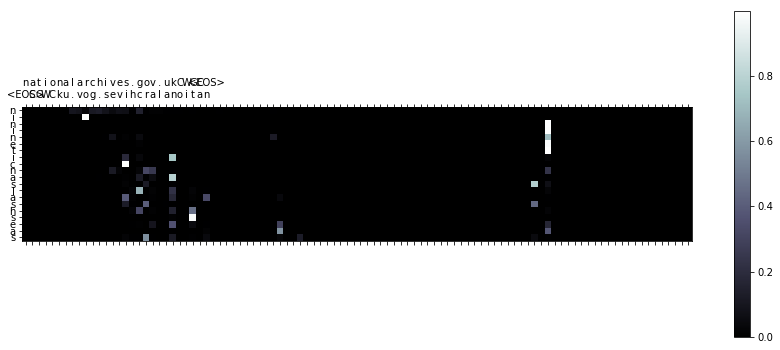

In [38]:
def debug_show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(111)
    #cax = ax.matshow(attentions.numpy(), cmap='bone')
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)
    # Set up axes
    #ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    #ax.set_xticklabels([''] + input_sentence + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)
    
    input_sentence = input_sentence + ['<EOS>']
    inp_arr = ["{}\n{}".format(input_sentence[i], input_sentence[-1-i]) for i in range(len(input_sentence))]
    ax.set_xticklabels([''] + inp_arr, rotation=0)

    # Show label at every tick
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

    plt.show()
    
def debug_eval_sample_show_attention():
    
    sample_row = balanced_data_sample_row()
    sample_row = balanced_data[balanced_data['before'].str.len()>15].sample(1).iloc[0]
    sample = sample_row['before'], sample_row['a_word_ind'], sample_row['class'], sample_row['sentence']

    output, decoded_output, decoder_attns_arr, sample = test_model_single_sample(None, 
                                                            return_more=True, sample=sample)
    print('input:  ', sample[0])
    print('output: ', ' '.join(decoded_output))
    print('target:   ', ''.join([words_after_common[w] for w in sample[1][:-1]]))

    attns = np.array([arr.data[0].cpu().numpy() for arr in decoder_attns_arr])

    debug_show_attention(list(sample[0]), decoded_output, attns)
    #plt.matshow(attns)

debug_eval_sample_show_attention()